# Visualization and explore the Wildfire data with Matplotlib, Pandas and Seaborn

This notebook will connect to a MySQL DB in the cloud which houses a combined table for wild
fires in the US and weather conditions during each fire. Independent features will be evaluated 
for collerlation and usefulness in a model. The goal of the model is to predict the fire intensity based on the fire features and the weather.

### Getting Started:
#### Importing the libraries 

In [24]:
%matplotlib inline
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np

from sqlalchemy import create_engine   #sql engine

import yellowbrick as yb

import pylab as pl
import seaborn as sns
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt


import config #database connection variables 

### Connect to mySQL database in the cloud
The config files stored in the same directory as the notebook 
contains the connection information 

In [2]:
# create sqlalchemy engine
# Skip this block if reading from disk
engine = create_engine("mysql+mysqlconnector://{user}:{password}@{host}/{dbname}"
                       .format(user=config.db_user,
                               password=config.db_pass,
                               dbname=config.db_main,
                               host=config.db_host))

### Query the machine learning table  
Setup the code to query the machine learning table in the database. Select all columns.


<i>Query the emissions and weather table until the final machine learning is setup. Limit the rows for initial exploration data</i>

In [3]:
#Create Query Statments
#Skip this block if reading from disk
queryWeather = """
SELECT *
FROM Weather;
"""
queryEmissions = """
SELECT *
FROM Emissions_Data
LIMIT 50000;
"""

In [4]:
#Execute Queries
#Skip this block if reading from disk
dfWeather = pd.read_sql(queryWeather, engine)
dfEmissions = pd.read_sql(queryEmissions, engine)

#close the database connection
engine.dispose()

### Save the data to disk for faster access in the future
Store data in default data sub directory or folder

In [5]:
#Execute Queries
#Skip this code if reading from disk
dfWeather.to_csv('data/weather.csv')
dfEmissions.to_csv('data/emissions.csv')

### Read data from disk previously stored for faster access

In [15]:
#Read the data from disk for faster access
dfWeather = pd.read_csv('data/weather.csv')
dfEmissions = pd.read_csv('data/emissions.csv')

### Display the head of data for check.

In [7]:
dfWeather.head()

,Unnamed: 0,Key,cluster_ref,lat,lon,temperature,humidity,precip_intensity,pressure,uv_index,visibility,wind_speed,wind_gust,Date
0,0,1,unknown,29.9614,-100.3969,89.32,0.50,NaN,NaN,9.0,9.997,9.21,17.25,2006-08-16 12:00:00
1,1,2,unknown,30.3707,-103.3322,82.84,0.41,NaN,NaN,10.0,9.997,4.69,11.36,2006-06-22 12:00:00
2,2,3,unknown,30.4200,-103.2347,85.95,0.22,NaN,NaN,10.0,9.997,5.37,13.20,2006-06-19 12:00:00
3,3,4,unknown,30.6933,-104.3193,84.48,0.13,0.0,NaN,10.0,9.997,2.68,8.99,2006-05-23 12:00:00
4,4,5,unknown,31.1047,-100.5903,82.00,0.58,0.0,1019.0,4.0,9.997,15.05,23.59,2006-10-03 12:00:00


In [26]:
dfEmissions.head()

,Unnamed: 0,Key,id,cluster_ref,lon,lat,year,doy,covertype,fuelcode,prefire_fuel,consumed_fuel,ECO2,ECO,ECH4,EPM2.5,fuel_moisture_class,BSEV,cwd_frac,duff_frac
0,0,1,0,2008_0,-81.0384,25.1958,2008,359,3,1600,6220.097576,1999.75772,3347.594423,153.981344,4.499455,23.797117,3.0,1.0,0.023231,0.082115
1,1,2,1,2008_0,-81.0404,25.1984,2008,359,3,1600,6220.097576,2041.37434,3417.260644,157.185824,4.593092,24.292355,3.0,2.0,0.022757,0.080441
2,2,3,2,2008_0,-81.0380,25.1981,2008,359,3,1600,6220.097576,1999.75772,3347.594423,153.981344,4.499455,23.797117,3.0,1.0,0.023231,0.082115
3,3,4,4,2008_0,-81.0594,25.2035,2008,359,3,1600,6220.097576,1999.75772,3347.594423,153.981344,4.499455,23.797117,3.0,1.0,0.023231,0.082115
4,4,5,5,2008_0,-81.0570,25.2032,2008,359,3,1600,6220.097576,2041.37434,3417.260644,157.185824,4.593092,24.292355,3.0,2.0,0.022757,0.080441


### Analyze the features in the machine learning table

<i> This example uses emissions until the machine learning table is setup. We will predict BSEV 1-4) Burn serverity</i>

In [16]:
#drop columns which are not relevant 
dfEmissions = dfEmissions.drop(columns=['Unnamed: 0', 'cluster_ref', 'Key', 'id', 'year'])



In [17]:
#show the shape of the data
print (dfEmissions.shape)

#show the data by BSEV
print(dfEmissions.groupby('BSEV').count())



(50000, 15)
        lon    lat    doy  covertype  fuelcode  prefire_fuel  consumed_fuel  \
BSEV                                                                          
1.0   10693  10693  10693      10693     10693         10693          10693   
2.0   32330  32330  32330      32330     32330         32330          32330   
3.0    6548   6548   6548       6548      6548          6548           6548   
4.0     429    429    429        429       429           429            429   

       ECO2    ECO   ECH4  EPM2.5  fuel_moisture_class  cwd_frac  duff_frac  
BSEV                                                                         
1.0   10693  10693  10693   10693                10693     10693      10693  
2.0   32330  32330  32330   32330                32330     32330      32330  
3.0    6548   6548   6548    6548                 6548      6548       6548  
4.0     429    429    429     429                  429       429        429  


### Visualize home many of each type of dependent variables we have (1-4)

Use seaborn to plot a count histogram. We have 4 separate categories.
1 (not burned), 2 (light), 3(med), 4 (heavy burn)

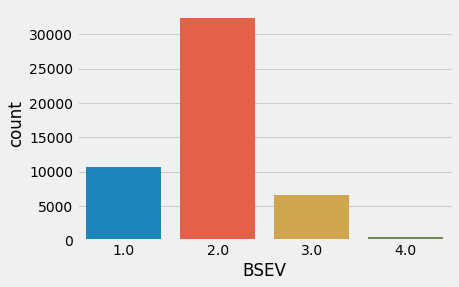

In [9]:
sns.countplot(dfEmissions['BSEV'],label="Count")
plt.show()

### Draw box diagram to see scale and quartiles of data

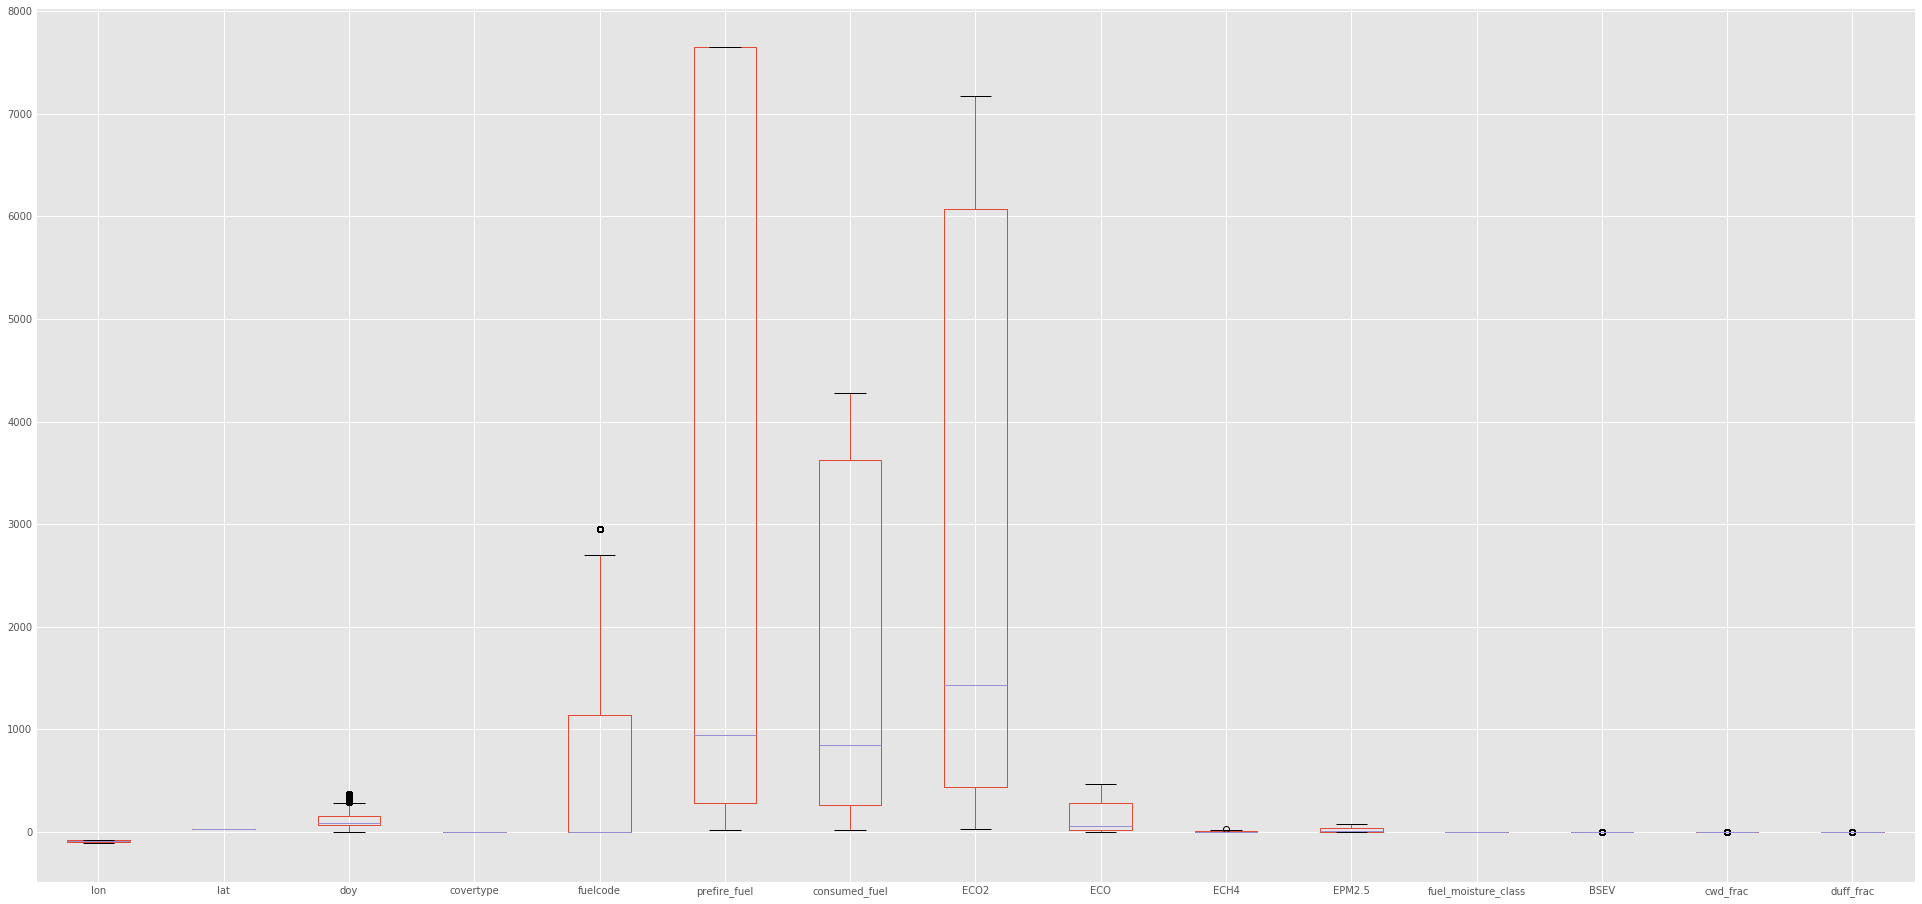

In [18]:
#draw box plot of see range of the data
matplotlib.style.use('ggplot')
dfEmissions.plot(kind='box',figsize=(30,15))

#data is on a very large scale with could affect some models
#scaling maybe needed

### View histogram of all numerical data to better understand the distribution
Graphs show some data is continous while others are categorical 
No normal distribution shown.Correlations can be seen between ECO/ECO2, cwd_frac/duff_frac

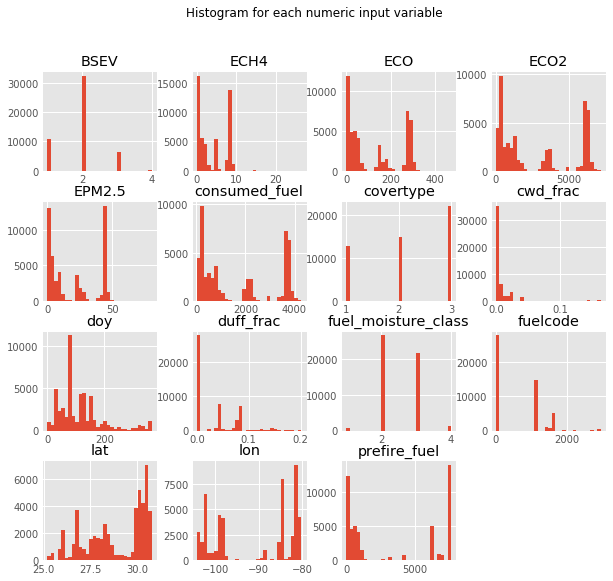

In [22]:
#historgram of all numerical data
dfEmissions.hist(bins=30, figsize=(9,9))
pl.suptitle("Histogram for each numeric input variable")
#plt.savefig('fruits_hist')
plt.show()

### Scatter matrix plot for the continous values - categorical does not present much value
<i>once agains shows relationships between cwd/duff, ECH4/EPM.2 These features likely be combined or
dropped</i> 

Text(0.5, 0.98, 'Scatter-matrix for each input variable')

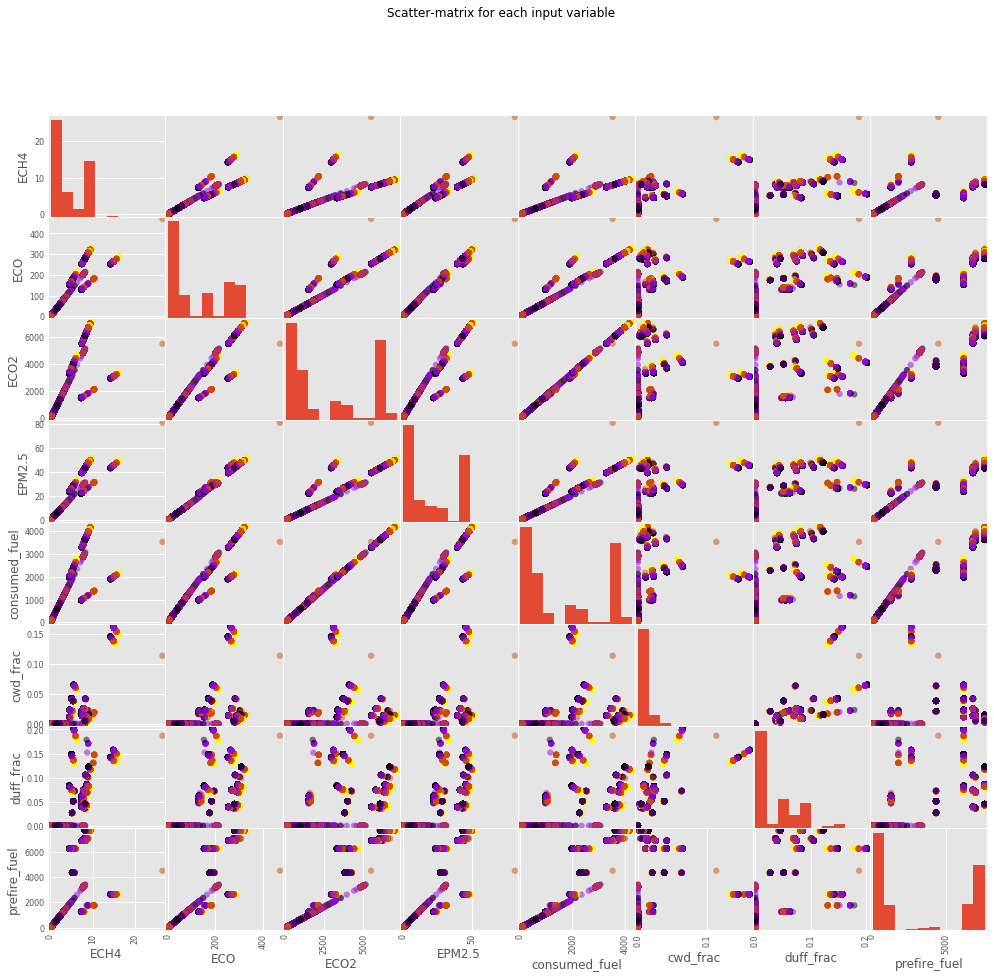

In [28]:
feature_names = ['ECH4', 'ECO', 'ECO2', 'EPM2.5', 'consumed_fuel', 'cwd_frac', 'duff_frac', 'prefire_fuel']
X = dfEmissions[feature_names]
y = dfEmissions['BSEV']
cmap = cm.get_cmap('gnuplot')
scatter = scatter_matrix(X, c = y, marker = 'o', s=40, hist_kwds={'bins':10}, figsize=(15,15), cmap = cmap)
plt.suptitle('Scatter-matrix for each input variable')


In [ ]:
### Show which features likely has the most impact of Burn Serverity 
<i> based on the data fuel code & fuel mositure are most predictive of burn serverity</i>

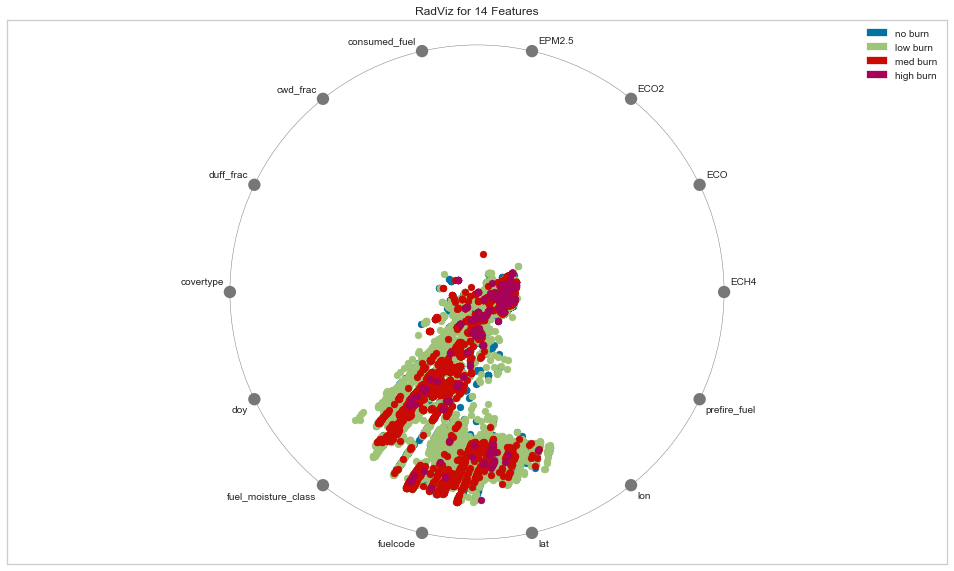

In [32]:
from yellowbrick.features import RadViz


feature_names = ['ECH4', 'ECO', 'ECO2', 'EPM2.5', 'consumed_fuel', 'cwd_frac', 'duff_frac', 'covertype','doy', 
                'fuel_moisture_class', 'fuelcode', 'lat', 'lon', 'prefire_fuel']

X = dfEmissions[feature_names]
y = dfEmissions['BSEV']

# Specify the target classes
classes = ["no burn", "low burn", "med burn", "high burn"]

# Instantiate the visualizer
visualizer = RadViz(classes=classes, features=feature_names, size=(1080, 720))

visualizer.fit(X, y)           # Fit the data to the visualizer
visualizer.transform(X)        # Transform the data
visualizer.show()              # Draw the data

### Show Random forest classier of the most important features to predict severity

<i> Lat/Lon and emissions are high important but not the covertype and fuel moisture type. I suspect this is because
scaling is not sued and those value types are very small and close together </i>

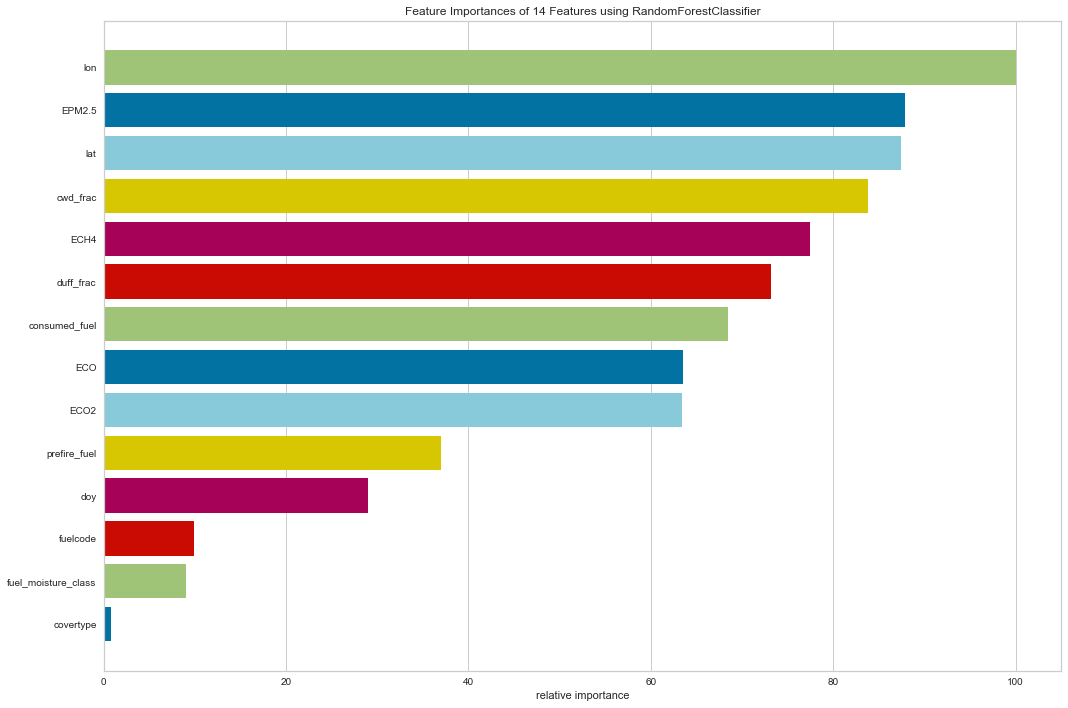

In [33]:
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.features import FeatureImportances

model = RandomForestClassifier(n_estimators=10)
viz = FeatureImportances(model, labels=feature_names, size=(1080, 720))

viz.fit(X, y)
# Note: the FeatureImportances visualizer is a model visualizer,
# not a feature visualizer, so it doesn't have a transform method!
viz.show()

### Visualize using rank 2D
<i> This shows a high digree of multicollinearity. Columsn can likely be combined or dropped </i>

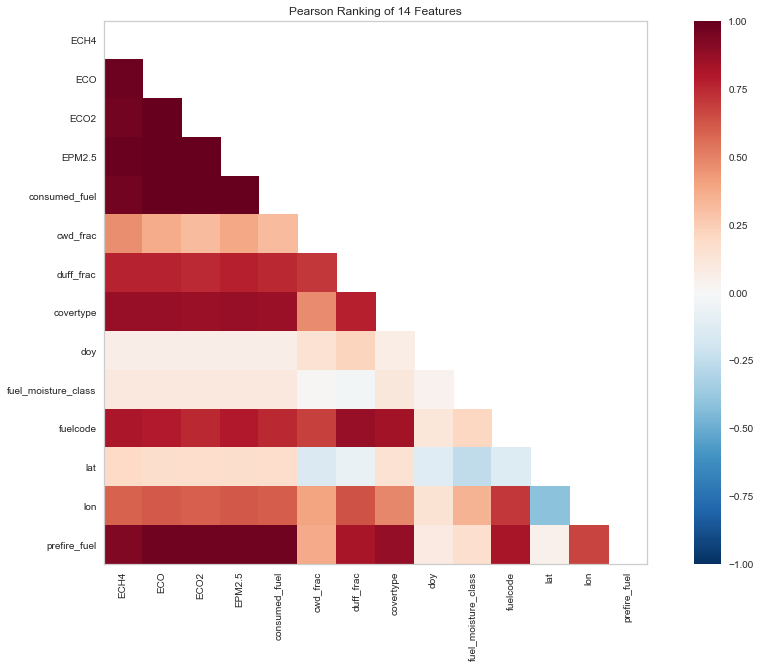

In [35]:
from yellowbrick.features import Rank2D

# Instantiate the visualizer with the Pearson ranking algorithm
visualizer = Rank2D(algorithm='pearson', features=feature_names, size=(1080, 720))

visualizer.fit(X, y)
visualizer.transform(X)
visualizer.show()